<a href="https://colab.research.google.com/github/asriva13/PINN/blob/main/Barycentric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Installs
! apt-get update
! sudo apt-get install texlive-latex-recommended 
! sudo apt install texlive-latex-extra
! sudo apt install dvipng
! sudo apt install cm-super
! pip install dmsh
! pip install optimesh

In [ ]:
#@title Imports
%matplotlib inline
import jax.numpy as np
import numpy
from jax import grad, jit, vmap, value_and_grad
from jax import random
from jax import jacfwd, jacrev
from jax.numpy import linalg
from jax.example_libraries import optimizers


# This import registers the 3D projection, but is otherwise unused.
#from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib.colors import LogNorm
import scipy as sc
from mpl_toolkits.axes_grid1 import ImageGrid
import string
import dmsh
import meshio
import optimesh
import meshplex
from numpy import loadtxt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.tri as tri
import scipy.io as sio
from matplotlib.tri import Triangulation, LinearTriInterpolator, CubicTriInterpolator

#from matplotlib import cm
#from matplotlib.ticker import LinearLocator, FormatStrFormatter
#%matplotlib inline

from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

key = random.PRNGKey(0)

In [ ]:
#@title Functions
##################
#Definitions relevant to NN architecture.
########################
def ReLU(x):
    """ Rectified Linear Unit (ReLU) activation function """
    return np.maximum(0, x)

def ReLU2(x):
    """ Rectified Linear Unit (ReLU) activation function """
    return (np.maximum(0, np.sign(x)*x**2))

def ReLU3(x):
    """ Rectified Linear Unit (ReLU) activation function """
    return (np.maximum(0, x**3))

def sigmoid(x):
    return 1./(1. + np.exp(-x))

def tanh(x):
    return 2.*sigmoid(2*x)-1.

def relu_layer(params, x):
    """ Simple ReLu layer for single sample """
    return ReLU(np.dot(params[0], x) + params[1])

def relu2_layer(params, x):
    """ Simple ReLu layer for single sample """
    return ReLU2(np.dot(params[0], x) + params[1])

def relu3_layer(params, x):
    """ Simple ReLu layer for single sample """
    return ReLU3(np.dot(params[0], x) + params[1])

def sigmoid_layer(params, x):
    """ Simple ReLu layer for single sample """
    return sigmoid(np.dot(params[0], x) + params[1])

def tanh_layer(params, x):
    """ Simple ReLu layer for single sample """
    return tanh(np.dot(params[0], x) + params[1])

############################
############################
#Basic geometry; o=0 for cc and 1 for c

def polygon(points,o=0):
  l = len(points[:,0])
  segments = numpy.zeros((l,4))
  for i in range(l-1):
    segments[i,:2]=points[i,:]
    segments[i,2:4]=points[i+1,:]
  i = i+1
  segments[i,:2]=points[i,:]
  segments[i,2:4]=points[0,:]  

  if o==0:
    return segments
  else:
    return numpy.flip(segments,axis=0)

###########################
#####Data reshape

def datareshapeMLP(x,numBatches):
  #numpy.random.shuffle(x)
  if numBatches>1:
    l=len(x)
    numCol=int(l/numBatches)
    x=x[:l*numCol]
    x=x.reshape(numBatches,numCol)
  else:
    x=x.reshape(1,len(x))

  return x


############################
###Initialize weights for an MLP
def initialize_mlp(sizes, key):
    """ Initialize the weights of all layers of a linear layer network """
    keys = random.split(key, len(sizes))
    # Initialize a single layer with Gaussian weights -  helper function
    def initialize_layer(m, n, key, scale=1.e-2):
        w_key, b_key = random.split(key)
        return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))
    return [initialize_layer(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

############################

############################
############################
def run_training(num_epochs, opt_state, inputx, inputy, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputx[batch,:]
        y=inputy[batch,:]
        params, opt_state, loss, Er = update(params, x, y, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def update(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, x, y)
    return get_params(opt_state), opt_state, value, Er


def error(params, x, y):
    ex = e_vect(x,y)
    e = u_vect(params,x,y) - e_vect(x,y)
    return np.sqrt(np.mean(e**2)/np.mean(ex**2))

###########################


def NN(params, x, y):
    """ Compute the forward pass for each example individually """
    activations = np.array([x,y])

    # Loop over the ReLU hidden layers
    for w, b in params[:-1]:
        activations = relu3_layer([w, b], activations)

    final_w, final_b = params[-1]
    final = np.sum(np.dot(final_w, activations)) + final_b

    return (final[0])


#################R functions and MVC

def dist(x1,y1,x2,y2):
  return np.sqrt((x2-x1)**2+(y2-y1)**2)

def linseg(x,y,x1,y1,x2,y2):
  L=dist(x1,y1,x2,y2)
  xc = (x1+x2)/2.
  yc = (y1+y2)/2.
  f = (1/L)*((x-x1)*(y2-y1) - (y-y1)*(x2-x1))
  t = (1/L)*((L/2.)**2-dist(x,y,xc,yc)**2)
  phi = np.sqrt(t**2+f**4)

  return np.sqrt(f**2 + (1/4.)*(phi - t)**2)

def R_eq(rho1,rho2,m):
  return rho1*rho2/((rho1**m + rho2**m)**(1/m))

def phi(x,y,segments):
  m = 1.
  # R = 1.
  R = 0.
  for i in range(len(segments[:,0])):
    rho = linseg(x,y,segments[i,0],segments[i,1],segments[i,2],segments[i,3])
    R = R + 1./rho**m
  R = 1/R**(1/m)

  return R

def tanaby2(r1,r2):
  return np.linalg.norm(np.cross(r1,r2))/(np.linalg.norm(r1)*np.linalg.norm(r2) + np.dot(r1,r2))

def meanValue(x,y,segments):

  p = 1.

  W = 0.
  i = len(segments[:,0])-1
  a1,b1 = segments[i,0]-x,segments[i,1]-y
  a2,b2 = segments[0,0]-x,segments[0,1]-y
  a3,b3 = segments[0,2]-x,segments[0,3]-y
  tm1 = abs(a1*b2-a2*b1)/(dist(a1,b1,0.,0.)*dist(a2,b2,0.,0.) + a1*a2 + b1*b2)
  t = abs(a2*b3-a3*b2)/(dist(a2,b2,0.,0.)*dist(a3,b3,0.,0.) + a2*a3 + b2*b3)
  w = (t + tm1)/dist(a2,b2,0.,0.)
  W = W + w**p

  for j in range(len(segments[:,0])-1):
    i=j+1
    a1,b1 = segments[j,0]-x,segments[j,1]-y
    a2,b2 = segments[i,0]-x,segments[i,1]-y
    a3,b3 = segments[i,2]-x,segments[i,3]-y
    tm1 = abs(a1*b2-a2*b1)/(dist(a1,b1,0.,0.)*dist(a2,b2,0.,0.) + a1*a2 + b1*b2)
    t = abs(a2*b3-a3*b2)/(dist(a2,b2,0.,0.)*dist(a3,b3,0.,0.) + a2*a3 + b2*b3)
    w = (t + tm1)/dist(a2,b2,0.,0.)
    W = W + w**p

  return 1./W**(1/p)


def affine(x,y,s1,s2):
  x1,y1,x2,y2 = s1[0],s1[1],s1[2],s1[3]
  if (y2==y1):
    g1 = x/(x2-x1) - x1/(x2-x1)
  elif (x2==x1):
    g1 = y/(y2-y1) - y1/(y2-y1)
  else:
    a = (1-(x2-x1))/(y2-y1)
    b = -x1-a*y1
    g1 = x + a*y +b

  x1,y1,x2,y2 = s2[2],s2[3],s2[0],s2[1]
  if (y2==y1):
    g2 = x/(x2-x1) - x1/(x2-x1)
  elif (x2==x1):
    g2 = y/(y2-y1) - y1/(y2-y1)
  else:
    a = (1-(x2-x1))/(y2-y1)
    b = -x1-a*y1
    g2 = x + a*y +b

  return g1, g2

def g(x,y,segments,n):
  #n is the row id where the first vertex is 1
  mu = 1.
  R = 0.
  l = len(segments[:,0])
  
  den = 0.
  for i in range(l):
    r = 1.
    for j in range(l):
      if(j!=i):
        r = r*linseg(x,y,segments[j,0],segments[j,1],segments[j,2],segments[j,3])**mu
    den = den + r
  
  if (n==0):
    g1, g2 = affine(x,y,segments[l-1,:],segments[0,:])
    r = 1.
    for j in range(l):
      if(j!=(l-1)):
        r = r*linseg(x,y,segments[j,0],segments[j,1],segments[j,2],segments[j,3])**mu
    w1 = r/den
   
    r = 1.
    for j in range(l):
      if(j!=0):
        r = r*linseg(x,y,segments[j,0],segments[j,1],segments[j,2],segments[j,3])  **mu  
    w2 = r/den
  else:
    g1, g2 = affine(x,y,segments[n-1,:],segments[n,:])

    r = 1.
    for j in range(l):
      if(j!=(n-1)):
        r = r*linseg(x,y,segments[j,0],segments[j,1],segments[j,2],segments[j,3])**mu
    w1 = r/den
   
    r = 1.
    for j in range(l):
      if(j!=n):
        r = r*linseg(x,y,segments[j,0],segments[j,1],segments[j,2],segments[j,3])**mu
    w2 = r/den

  g = g1*w1 + g2*w2

  return g


gxx = grad(grad(g,0),0) 
gyy = grad(grad(g,1),1)
phixx = grad(grad(phi,0),0) 
phix = grad(phi,0) 
phiyy = grad(grad(phi,1),1)
meanValuexx = grad(grad(meanValue,0),0)
meanValueyy = grad(grad(meanValue,1),1)

g_vect = vmap(g, (0, 0, None, None))
gxx_vect = vmap(gxx, (0, 0, None))
gyy_vect = vmap(gyy, (0, 0, None))
R_vect = vmap(phi, (0, 0, None))
phix_vect = vmap(phix, (0, 0, None))
phixx_vect = vmap(phixx, (0, 0, None))
phiyy_vect = vmap(phiyy, (0, 0, None))
meanValue_vect = vmap(meanValue, (0, 0, None))
meanValuexx_vect = vmap(meanValuexx, (0, 0, None))
meanValueyy_vect = vmap(meanValueyy, (0, 0, None))
#####################

def gridValues(x,y,z):
  l = int(numpy.sqrt(len(x)))
  grid_x, grid_y = numpy.mgrid[min(x):max(x):l*1j, min(y):max(y):l*1j]
  values = z.reshape((l,l))
  return grid_x.T,grid_y.T,values


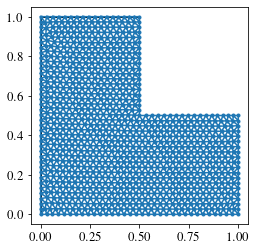

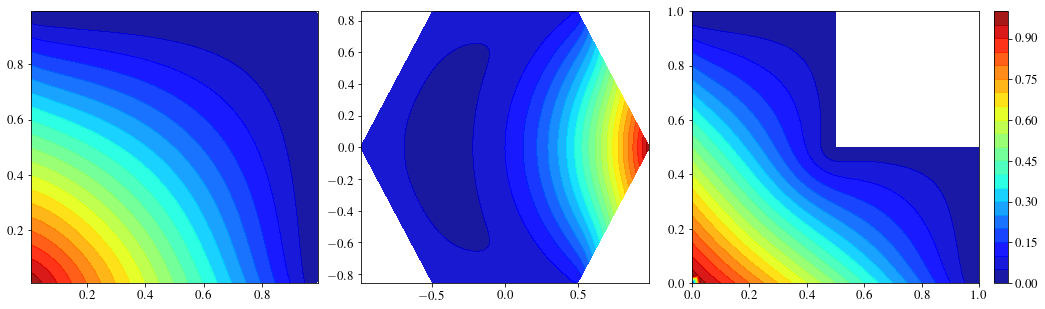

In [ ]:
#@title g functions for various polygons
numBatches = 1
num_epochs = 50000

#Hexagon
r = 1.
c = np.cos(np.pi/3.)
s = np.sin(np.pi/3.)
#Outer square
p = numpy.array([[r,0.],[r*c,r*s],[-r*c,r*s],[-r,0.],[-r*c,-r*s],[r*c,-r*s]])
segments = polygon(p,0)

# #Square
# p = numpy.array([[0.,0.],[1.,0.],[1.,1.],[0.,1.]])
# segments = polygon(p,0)

geo = dmsh.Polygon(p)
X, cells = dmsh.generate(geo, 0.03)
# optionally optimize the mesh
X, cells = optimesh.optimize_points_cells(X, cells, "CVT (full)", 1.0e-10, 100)
mesh = meshplex.MeshTri(X, cells)

#interior
xh = mesh.cell_centroids[:,0]
yh = mesh.cell_centroids[:,1]
gh = g_vect(xh,yh,segments,0)

#Square
p = numpy.array([[0.,0.],[1.,0.],[1.,1.],[0.,1.]])
segments = polygon(p,0)
geo = dmsh.Polygon(p)
X, cells = dmsh.generate(geo, 0.03)
# optionally optimize the mesh
X, cells = optimesh.optimize_points_cells(X, cells, "CVT (full)", 1.0e-10, 100)
mesh = meshplex.MeshTri(X, cells)

#interior
xs = mesh.cell_centroids[:,0]
ys = mesh.cell_centroids[:,1]
gS = g_vect(xs,ys,segments,0)


#L
dd = .5
p = numpy.array([[0.,0.],[1.,0.],[1.,dd],[dd,dd],[dd,1.],[0.,1.]])
segments = polygon(p,0)
geo = dmsh.Polygon(p)
X, cells = dmsh.generate(geo, 0.03)
# optionally optimize the mesh
X, cells = optimesh.optimize_points_cells(X, cells, "CVT (full)", 1.0e-10, 100)
mesh = meshplex.MeshTri(X, cells)

#interior
xL = mesh.cell_centroids[:,0]
yL = mesh.cell_centroids[:,1]
gL = g_vect(xL,yL,segments,0)

triang = tri.Triangulation(xL, yL)
x2 = xL[triang.triangles].mean(axis=1) 
y2 = yL[triang.triangles].mean(axis=1)
cond1 = x2 >dd
cond2 = y2 >dd
mask = numpy.where((cond1 & cond2),1,0)
# apply masking
triang.set_mask(mask)

dmsh.helpers.show(X, cells, geo)
sio.savemat('L.mat',{'X':X,'cells':cells})

plt.rcParams.update({'font.size': 13})
######
#Plots

fig = plt.figure(figsize=(17, 5))
gs = gridspec.GridSpec(1, 3)
gs.update(wspace=0.15)
# gs.update(hspace=.25)
# ax1 = plt.subplot(gs[0, 0], projection = '3d')
# ax2 = plt.subplot(gs[0, 1], projection = '3d')
# ax3 = plt.subplot(gs[0, 2], projection = '3d')
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])

# ax1.plot_trisurf(xs,ys,gS, cmap=plt.cm.Spectral)
# ax2.plot_trisurf(xh,yh,gh, cmap=plt.cm.Spectral)
# ax3.plot_trisurf(xL,yL,gL, cmap=plt.cm.Spectral)

ax1.tricontourf(xs,ys,gS, levels=20, cmap=plt.cm.jet, alpha=0.9)
ax2.tricontourf(xh,yh,gh, levels=20, cmap=plt.cm.jet, alpha=0.9)
# im = ax3.tricontourf(triang,gL, levels=20, cmap=plt.cm.jet, alpha=0.9)
gLt = g_vect(X[:,0],X[:,1],segments,0)
gL=numpy.array(gLt)
gL[numpy.isnan(gL)] = 0.
gL[numpy.isinf(gL)] = 0.
im = ax3.tricontourf(X[:,0],X[:,1], cells, gL, levels=20, cmap=plt.cm.jet, alpha=0.9)

axins = inset_axes(ax3,
                   width="5%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax3.transAxes,
                   borderpad=0,
                   )
fig.colorbar(im, cax=axins)

# plt.tight_layout()
fig.savefig('Barycentric-g.pdf', format='pdf', bbox_inches = 'tight',
    pad_inches = 0.2)


plt.show()

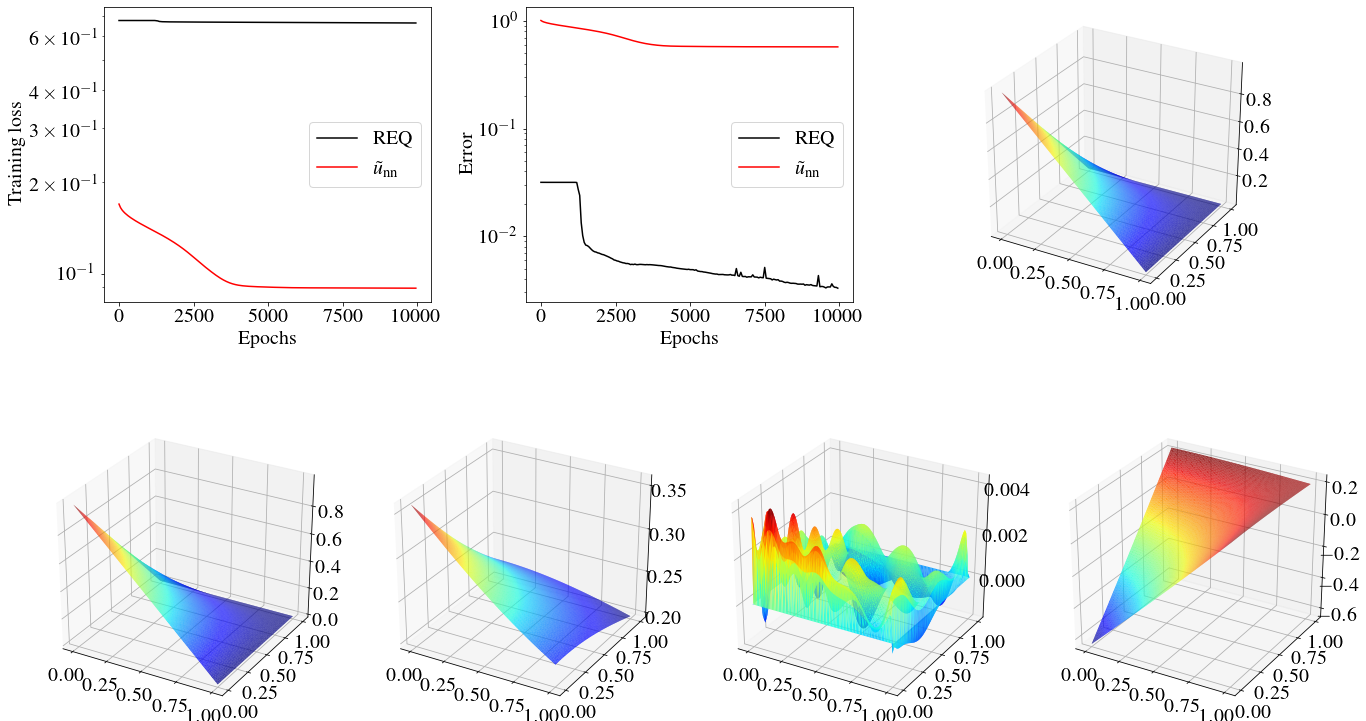

In [ ]:
#@title Solving the problem on a square
#Convex polygon
numBatches = 1
num_epochs = 10000

#Domain boundary
ax,bx = 0.,1.
ay,by = 0.,1.

p = numpy.array([[0.,0.],[1.,0.],[1.,1.],[0.,1.]])
segments = polygon(p,0)

dx = 0.00001
#interior
inputx = numpy.linspace(ax+dx, bx-dx, num=70)
inputy = numpy.linspace(ay+dx, by-dx, num=70)
inputx, inputy = np.meshgrid(inputx, inputy)
inputx, inputy = inputx.flatten(), inputy.flatten()
inputx = datareshapeMLP(inputx,numBatches)
inputy = datareshapeMLP(inputy,numBatches)

#For plotting
x = numpy.linspace(ax+dx, bx-dx, num=100)
y = numpy.linspace(ay+dx, by-dx, num=100)
x, y = np.meshgrid(x, y)
x, y = x.flatten(), y.flatten()

# #Square
# p = numpy.array([[0.,0.],[1.,0.],[1.,1.],[0.,1.]])
# segments = polygon(p,0)
# geo = dmsh.Polygon(p)
# X, cells = dmsh.generate(geo, 0.01)
# # optionally optimize the mesh
# X, cells = optimesh.optimize_points_cells(X, cells, "CVT (full)", 1.0e-10, 100)
# mesh = meshplex.MeshTri(X, cells)

# #For plotting interior
# x = mesh.cell_centroids[:,0]
# y = mesh.cell_centroids[:,1]

# #interior
# inputx = mesh.cell_centroids[:,0]
# inputy = mesh.cell_centroids[:,1]
# inputx = datareshapeMLP(inputx,numBatches)
# inputy = datareshapeMLP(inputy,numBatches)


#Square
p = numpy.array([[0.01,0.],[.99,0.],[1.,.01],[1.,.99],[.99,1.],[.01,1.],[0.,.99],[0.,.01]])
segments1 = polygon(p,0)
geo = dmsh.Polygon(p)
X, cells = dmsh.generate(geo, 0.03)
# optionally optimize the mesh
X, cells = optimesh.optimize_points_cells(X, cells, "CVT (full)", 1.0e-10, 100)
mesh = meshplex.MeshTri(X, cells)

#Boundary points
Xb = X[mesh.is_boundary_point]
xb, yb = Xb[:,0], Xb[:,1]

#NN
layer_sizes = [2, 50, 50, 1]

def exact(x,y):
  return (1-x)*(1-y)

e_vect = vmap(exact, (0, 0))

###################################
#R equiv

# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

def uR(params, x, y):
    return phi(x,y,segments)*NN(params,x,y)+g(x,y,segments,0)

def lossR(params, x, y):
    eq = dudx_vect(params, x, y)**2 + dudy_vect(params, x, y)**2
    return np.mean(eq)

grad1 = grad(uR,1)
grad2 = grad(uR,2)
dudx_vect = vmap(grad1, (None, 0, 0))
dudy_vect = vmap(grad2, (None, 0, 0))
u_vect = vmap(uR, (None, 0, 0))


def run_trainingR(num_epochs, opt_state, inputx, inputy, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputx[batch,:]
        y=inputy[batch,:]
        params, opt_state, loss, Er = updateR(params, x, y, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def updateR(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(lossR)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, x, y)
    return get_params(opt_state), opt_state, value, Er

# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_trainingR(num_epochs, opt_state, inputx, inputy, numBatches)

params = get_params(opt_state)

errorR1 = e
lossR1 = train_loss
approxSolnR1 = numpy.array(u_vect(params, x, y))
approxSolnR1[numpy.isnan(approxSolnR1)] = 0.

exactSoln1 = numpy.array(e_vect(x,y))
##########################################################


###################################
#MVP

# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

def uM(params, x, y):
    return meanValue(x,y,segments)*NN(params,x,y)+g(x,y,segments,0)

def lossM(params, x, y):
    eq = dudx_vect(params, x, y)**2 + dudy_vect(params, x, y)**2
    return np.mean(eq)

grad1 = grad(uM,1)
grad2 = grad(uM,2)
dudx_vect = vmap(grad1, (None, 0, 0))
dudy_vect = vmap(grad2, (None, 0, 0))
u_vect = vmap(uM, (None, 0, 0))


def run_trainingM(num_epochs, opt_state, inputx, inputy, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputx[batch,:]
        y=inputy[batch,:]
        params, opt_state, loss, Er = updateM(params, x, y, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def updateM(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(lossM)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, x, y)
    return get_params(opt_state), opt_state, value, Er

# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_trainingM(num_epochs, opt_state, inputx, inputy, numBatches)

params = get_params(opt_state)

errorM1 = e
lossM1 = train_loss
approxSolnM1 = numpy.array(u_vect(params, x, y))
approxSolnM1[numpy.isnan(approxSolnM1)] = 0.

##########################################################

###################################
#No Dirichlet

layer_sizes = [2, 50, 50, 1]

# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

def uNBC(params, x, y):
    return NN(params,x,y)

def lossNBC(params, x, y):
    eq = dudx_vect(params, x, y)**2 + dudy_vect(params, x, y)**2
    bc = u_vect(params,xb,yb)-g_vect(xb,yb,segments,0)
    return np.mean(eq) + 1.*np.mean(bc**2)

grad1 = grad(uNBC,1)
grad2 = grad(uNBC,2)
dudx_vect = vmap(grad1, (None, 0, 0))
dudy_vect = vmap(grad2, (None, 0, 0))
u_vect = vmap(uNBC, (None, 0, 0))


def run_trainingNBC(num_epochs, opt_state, inputx, inputy, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputx[batch,:]
        y=inputy[batch,:]
        params, opt_state, loss, Er = updateNBC(params, x, y, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def updateNBC(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(lossNBC)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, x, y)
    return get_params(opt_state), opt_state, value, Er
    
# Defining an optimizer in Jax
step_size = 1e-4
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_trainingNBC(num_epochs, opt_state, inputx, inputy, numBatches)

params = get_params(opt_state)

errorNBC1 = e
lossNBC1 = train_loss
approxSolnNBC1 = numpy.array(u_vect(params, x, y))
approxSolnNBC1[numpy.isnan(approxSolnNBC1)] = 0.

##########################################################

e_dx = 50

plt.rcParams.update({'font.size': 20})
######
#Plots

fig = plt.figure(figsize=(24, 13))
gs = gridspec.GridSpec(2, 16)
gs.update(wspace=.15)
gs.update(hspace=.4)
ax1 = plt.subplot(gs[0, 1:5])
ax2 = plt.subplot(gs[0, 6:10])
ax3 = plt.subplot(gs[0, 11:15], projection = '3d')
ax4 = plt.subplot(gs[1, 0:4], projection = '3d')
ax5 = plt.subplot(gs[1, 4:8], projection = '3d')
ax6 = plt.subplot(gs[1, 8:12], projection = '3d')
ax7 = plt.subplot(gs[1, 12:16], projection = '3d')

ax1.plot(range(num_epochs)[::e_dx],lossR1[::e_dx], color="black", label='REQ')
# ax1.plot(range(num_epochs)[::e_dx],lossM1[::e_dx], color="blue", label='MVP')
ax1.plot(range(num_epochs)[::e_dx],lossNBC1[::e_dx], color="red", label='$\\tilde{u}_\mathrm{nn}$')
# ax1.set_title('$k=1$')
ax1.set_yscale('log')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training loss')
ax1.legend(loc='best')


ax2.plot(range(num_epochs)[::e_dx],errorR1[::e_dx], color="black", label='REQ')
# ax2.plot(range(num_epochs)[::e_dx],errorM1[::e_dx], color="blue", label='MVP')
ax2.plot(range(num_epochs)[::e_dx],errorNBC1[::e_dx], color="red", label='$\\tilde{u}_\mathrm{nn}$')
# ax1.set_title('$k=1$')
ax2.set_yscale('log')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Error')
ax2.legend(loc='best')

ax3.plot_trisurf(x, y, exactSoln1, cmap=plt.cm.jet, alpha=0.9)
# ax3.set_title('Exact solution')
# ax3.set_xlabel('$x$')
# ax3.set_ylabel('$y$')


ax4.plot_trisurf(x, y, approxSolnR1, cmap=plt.cm.jet, alpha=0.9)
# ax4.set_title('$R-$equivalence')
# ax4.set_xlabel('$x$')
# ax4.set_ylabel('$y$')

ax5.plot_trisurf(x, y, approxSolnNBC1, cmap=plt.cm.jet, alpha=0.9)
# ax5.set_title('Std. PINN')
# ax5.set_xlabel('$x$')
# ax5.set_ylabel('$y$')

ax6.plot_trisurf(x, y, approxSolnR1-exactSoln1, cmap=plt.cm.jet, alpha=0.9)
# ax6.set_title('$R-$equivalence error')
# ax6.set_xlabel('$x$')
# ax6.set_ylabel('$y$')
# ax6.set_zlim(-.05,.05)

ax7.plot_trisurf(x, y, approxSolnNBC1-exactSoln1, cmap=plt.cm.jet, alpha=0.9)
# ax7.set_title('Std. PINN error')
# ax7.set_xlabel('$x$')
# ax7.set_ylabel('$y$')

ax3.locator_params(nbins=5)
ax4.locator_params(nbins=5)
ax5.locator_params(nbins=5)
ax6.locator_params(nbins=5)
ax7.locator_params(nbins=5)

# axins = inset_axes(ax6,
#                    width="5%",  # width = 5% of parent_bbox width
#                    height="100%",  # height : 50%
#                    loc='lower left',
#                    bbox_to_anchor=(1.05, 0., 1, 1),
#                    bbox_transform=ax6.transAxes,
#                    borderpad=0,
#                    )
# fig.colorbar(im, cax=axins)

# plt.tight_layout()
fig.savefig('barycenter-square.pdf', format='pdf', bbox_inches = 'tight',
    pad_inches = 0.2)


plt.show()


epoch:   0 loss: 2.022754
epoch: 1000 loss: 1.556745
epoch: 2000 loss: 1.551363
epoch: 3000 loss: 1.547450
epoch: 4000 loss: 1.538663
epoch: 5000 loss: 1.536368
epoch: 6000 loss: 1.535613
epoch: 7000 loss: 1.535240
epoch: 8000 loss: 1.534730
epoch: 9000 loss: 1.533637
epoch:   0 loss: 2.021815
epoch: 1000 loss: 1.508935
epoch: 2000 loss: 1.503033
epoch: 3000 loss: 1.501280
epoch: 4000 loss: 1.500576
epoch: 5000 loss: 1.499931
epoch: 6000 loss: 1.499192
epoch: 7000 loss: 1.498577
epoch: 8000 loss: 1.497932
epoch: 9000 loss: 1.497114


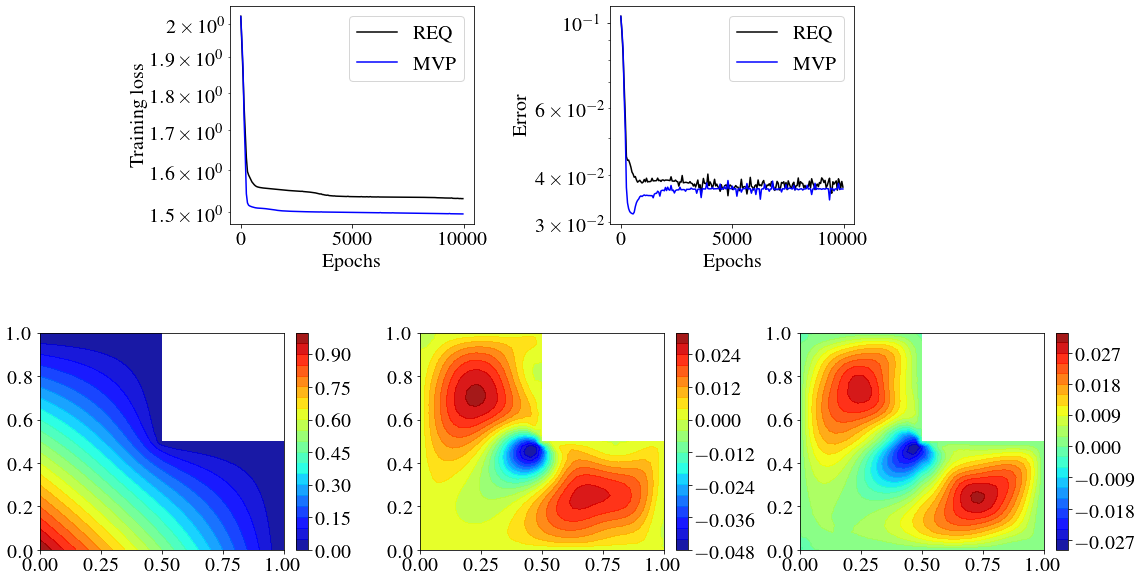

In [ ]:
#@title Solving the problem on a non-convex domain
#L
numBatches = 1
num_epochs = 10000


#L
dd = .5
p = numpy.array([[0.,0.],[1.,0.],[1.,dd],[dd,dd],[dd,1.],[0.,1.]])
segments = polygon(p,0)
geo = dmsh.Polygon(p)
X, cells = dmsh.generate(geo, 0.02)
# optionally optimize the mesh
X, cells = optimesh.optimize_points_cells(X, cells, "CVT (full)", 1.0e-10, 100)
mesh = meshplex.MeshTri(X, cells)


#interior
inputx = mesh.cell_centroids[:,0]
inputy = mesh.cell_centroids[:,1]
inputx = datareshapeMLP(inputx,numBatches)
inputy = datareshapeMLP(inputy,numBatches)


# dx=.00001
# dx=0.
# #For boundary
# p = numpy.array([[0.+dx,0.+dx],[1.+dx,0.+dx],[1.+dx,dd+dx],[dd+dx,dd+dx],[dd+dx,1.+dx],[0.+dx,1.+dx]])
# # p=p*1.02
# segments1 = polygon(p,0)
# geo = dmsh.Polygon(p)
# X, cells = dmsh.generate(geo, 0.03)
# # optionally optimize the mesh
# X, cells = optimesh.optimize_points_cells(X, cells, "CVT (full)", 1.0e-10, 100)
# mesh = meshplex.MeshTri(X, cells)

# #Boundary points
# Xb = X[mesh.is_boundary_point]
# xb, yb = Xb[:,0], Xb[:,1]

#NN
layer_sizes = [2, 50, 50, 1]


mat_contents = sio.loadmat('harmonic_vertex-1.mat')
X,cells,u = mat_contents['vertices'],mat_contents['elements'],mat_contents['u']
u = u[:,0]
cells=cells-1
ex = u
xi,yi=X[:,0],X[:,1]

t = Triangulation(xi,yi,cells)
exI = CubicTriInterpolator(t,ex)
# exR = CubicTriInterpolator(t,approxSolnR1)
# exM = CubicTriInterpolator(t,approxSolnM1)

dx=.001
p = numpy.array([[0.+dx,0.+dx],[1.-dx,0.+dx],[1.-dx,dd-dx],[dd-dx,dd-dx],[dd-dx,1.-dx],[0.+dx,1.-dx]])
segments1 = polygon(p,0)
geo = dmsh.Polygon(p)
X, cells = dmsh.generate(geo, 0.03)
# optionally optimize the mesh
X, cells = optimesh.optimize_points_cells(X, cells, "CVT (full)", 1.0e-10, 100)
mesh = meshplex.MeshTri(X, cells)
xi,yi=X[:,0],X[:,1]

ex = exI(X[:,0],X[:,1])
# exR = exR(X[:,0],X[:,1])
# exM = exM(X[:,0],X[:,1])

###################################
#R equiv

# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

def uR(params, x, y):
    return phi(x,y,segments)*NN(params,x,y)+g(x,y,segments,0)

def errorR(params, x, y):
    e = u_vect(params,xi,yi) - ex
    return np.sqrt(np.mean(e**2)/np.mean(ex**2))

def lossR(params, x, y):
    eq = dudx_vect(params, x, y)**2 + dudy_vect(params, x, y)**2
    return np.mean(eq**2)

grad1 = grad(uR,1)
grad2 = grad(uR,2)
dudx_vect = vmap(grad1, (None, 0, 0))
dudy_vect = vmap(grad2, (None, 0, 0))
u_vect = vmap(uR, (None, 0, 0))


def run_trainingR(num_epochs, opt_state, inputx, inputy, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputx[batch,:]
        y=inputy[batch,:]
        params, opt_state, loss, Er = updateR(params, x, y, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def updateR(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(lossR)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    Er = errorR(params, x, y)
    return get_params(opt_state), opt_state, value, Er

# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_trainingR(num_epochs, opt_state, inputx, inputy, numBatches)

params = get_params(opt_state)

errorR1 = e
lossR1 = train_loss

approxSolnR1 = numpy.array(u_vect(params, X[:,0], X[:,1]))
approxSolnR1[numpy.isnan(approxSolnR1)] = 0.

##########################################################


###################################
#MVP

# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

def uM(params, x, y):
    return meanValue(x,y,segments)*NN(params,x,y)+g(x,y,segments,0)

def errorM(params, x, y):
    e = u_vect(params,xi,yi) - ex
    return np.sqrt(np.mean(e**2)/np.mean(ex**2))

def lossM(params, x, y):
    eq = dudx_vect(params, x, y)**2 + dudy_vect(params, x, y)**2
    return np.mean(eq**2)

grad1 = grad(uM,1)
grad2 = grad(uM,2)
dudx_vect = vmap(grad1, (None, 0, 0))
dudy_vect = vmap(grad2, (None, 0, 0))
u_vect = vmap(uM, (None, 0, 0))


def run_trainingM(num_epochs, opt_state, inputx, inputy, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputx[batch,:]
        y=inputy[batch,:]
        params, opt_state, loss, Er = updateM(params, x, y, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def updateM(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(lossM)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    Er = errorM(params, x, y)
    return get_params(opt_state), opt_state, value, Er

# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_trainingM(num_epochs, opt_state, inputx, inputy, numBatches)

params = get_params(opt_state)

errorM1 = e
lossM1 = train_loss
approxSolnM1 = numpy.array(u_vect(params, X[:,0], X[:,1]))
approxSolnM1[numpy.isnan(approxSolnM1)] = 0.

##########################################################

# ###################################
# #No Dirichlet

# # Return a list of tuples of layer weights
# params = initialize_mlp(layer_sizes, key)

# def uNBC(params, x, y):
#     return NN(params,x,y)

# def errorNBC(params, x, y):
#     e = u_vect(params,xi,yi) - ex
#     return np.sqrt(np.mean(e**2)/np.mean(ex**2))

# def lossNBC(params, x, y):
#     eq = dudx_vect(params, x, y)**2 + dudy_vect(params, x, y)**2
#     bc = u_vect(params,xb,yb)-g_vect(xb,yb,segments,0)
#     return np.mean(eq) + np.mean(bc**2)

# grad1 = grad(uNBC,1)
# grad2 = grad(uNBC,2)
# dudx_vect = vmap(grad1, (None, 0, 0))
# dudy_vect = vmap(grad2, (None, 0, 0))
# u_vect = vmap(uNBC, (None, 0, 0))


# def run_trainingNBC(num_epochs, opt_state, inputx, inputy, numBatches=1):
#     """ Implements a learning loop over epochs. """
#     # Initialize placeholder for loggin
#     E = []
#     train_loss = []
#     train_loss_p = []

#     # Get the initial set of parameters
#     params = get_params(opt_state)

#     # Loop over the training epochs
#     for epoch in range(num_epochs):

#       for batch in range (numBatches):
#         x=inputx[batch,:]
#         y=inputy[batch,:]
#         params, opt_state, loss, Er = updateNBC(params, x, y, opt_state)
        
#       train_loss.append(loss)
#       E.append(Er)

#       if epoch % 1000 == 0:
#         print('epoch: %3d loss: %.6f' % (epoch, loss))

#     return train_loss, opt_state, E

# def updateNBC(params, x, y, opt_state):
#     """ Compute the gradient for a batch and update the parameters """
#     value, grads = value_and_grad(lossNBC)(params, x, y)
#     opt_state = opt_update(0, grads, opt_state)
#     Er = errorNBC(params, x, y)
#     return get_params(opt_state), opt_state, value, Er
    
# # Defining an optimizer in Jax
# step_size = 1e-3
# opt_init, opt_update, get_params = optimizers.adam(step_size)
# opt_state = opt_init(params)

# train_loss, opt_state, e = run_trainingNBC(num_epochs, opt_state, inputx, inputy, numBatches)

# params = get_params(opt_state)

# errorNBC1 = e
# lossNBC1 = train_loss
# approxSolnNBC1 = numpy.array(u_vect(params, X[:,0], X[:,1]))
# approxSolnNBC1[numpy.isnan(approxSolnNBC1)] = 0.

# ##########################################################


# t = Triangulation(xi,yi,cells)
# exI = CubicTriInterpolator(t,ex)
# exR = CubicTriInterpolator(t,approxSolnR1)
# exM = CubicTriInterpolator(t,approxSolnM1)

# dx=.05
# p = numpy.array([[0.+dx,0.+dx],[1.-dx,0.+dx],[1.-dx,dd-dx],[dd-dx,dd-dx],[dd-dx,1.-dx],[0.+dx,1.-dx]])
# segments1 = polygon(p,0)
# geo = dmsh.Polygon(p)
# X, cells = dmsh.generate(geo, 0.03)
# # optionally optimize the mesh
# X, cells = optimesh.optimize_points_cells(X, cells, "CVT (full)", 1.0e-10, 100)
# mesh = meshplex.MeshTri(X, cells)

# exI = exI(X[:,0],X[:,1])
# exR = exR(X[:,0],X[:,1])
# exM = exM(X[:,0],X[:,1])


e_dx = 50

plt.rcParams.update({'font.size': 20})
######
#Plots

fig = plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(2, 6)
gs.update(wspace=2.5)
gs.update(hspace=.5)
ax1 = plt.subplot(gs[0, 1:3])
ax2 = plt.subplot(gs[0, 3:5])
ax3 = plt.subplot(gs[1, 0:2])
ax4 = plt.subplot(gs[1, 2:4])
ax5 = plt.subplot(gs[1, 4:6])

ax1.plot(range(num_epochs)[::e_dx],lossR1[::e_dx], color="black", label='REQ')
ax1.plot(range(num_epochs)[::e_dx],lossM1[::e_dx], color="blue", label='MVP')
# ax1.plot(range(num_epochs)[::e_dx],lossNBC1[::e_dx], color="red", label='$\\tilde{u}_\mathrm{nn}$')
# ax1.set_title('$k=1$')
ax1.set_yscale('log')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training loss')
ax1.legend(loc='best')


ax2.plot(range(num_epochs)[::e_dx],errorR1[::e_dx], color="black", label='REQ')
ax2.plot(range(num_epochs)[::e_dx],errorM1[::e_dx], color="blue", label='MVP')
# ax2.plot(range(num_epochs)[::e_dx],errorNBC1[::e_dx], color="red", label='$\\tilde{u}_\mathrm{nn}$')
# ax1.set_title('$k=1$')
ax2.set_yscale('log')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Error')
ax2.legend(loc='best')

im3 = ax3.tricontourf(X[:,0], X[:,1],cells,ex, levels=20, cmap=plt.cm.jet, alpha=0.9)
# ax3.set_xlabel('$x$')
# ax3.set_ylabel('$y$')
ax3.set_xlim(0.,1.)
ax3.set_ylim(0.,1.)
axins = inset_axes(ax3,
                   width="5%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax3.transAxes,
                   borderpad=0,
                   )
fig.colorbar(im3, cax=axins)


im4 = ax4.tricontourf(X[:,0], X[:,1],cells,approxSolnR1-ex, levels=20, cmap=plt.cm.jet, alpha=0.9)
ax4.set_xlim(0.,1.)
ax4.set_ylim(0.,1.)
# ax4.set_xlabel('$x$')
# ax4.set_ylabel('$y$')
axins = inset_axes(ax4,
                   width="5%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax4.transAxes,
                   borderpad=0,
                   )
fig.colorbar(im4, cax=axins)

im5 = ax5.tricontourf(X[:,0], X[:,1],cells,approxSolnM1-ex, levels=20, cmap=plt.cm.jet, alpha=0.9)
ax5.set_xlim(0.,1.)
ax5.set_ylim(0.,1.)
# ax5.set_xlabel('$x$')
# ax5.set_ylabel('$y$')
axins = inset_axes(ax5,
                   width="5%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax5.transAxes,
                   borderpad=0,
                   )
fig.colorbar(im5, cax=axins)

fig.savefig('barycentric-L1.pdf', format='pdf', bbox_inches = 'tight',
    pad_inches = 0.2)


plt.show()
